In [16]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib
from scipy.optimize import curve_fit

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')
pd.set_option('display.max_rows', 500)

def extrapolate(df=None):
    """add exprapolation function, since Pandas does not that ability"""

    # Function to curve fit to the data
    def func(x, a, b): #, c):
        r = a * np.exp(-b * x)# + c
        return r # if (r > 0).all() else np.Inf * np.ones(x.shape)

    # Convert to DataFrame, if needed
    if isinstance(df, pd.Series):
        df = pd.DataFrame(df)

    # Initial parameter guess, just to kick off the optimization
    guess = (1, 1e-6)#, 1)
    avg_guess = ()

    # Temporarily remove dates and make index numeric
    di = df.index
    if isinstance(df.columns, pd.core.index.MultiIndex):
        df = df.reset_index().drop(di.name, axis=1, level=0)
    else:
        df = df.reset_index().drop(di.name, axis=1)

    # Place to store function parameters for each column
    col_params = {}

    # Curve fit each column
    for col in df.columns:
        # Create copy of data to remove NaNs for curve fitting
        fit_df = df[[col]].dropna()
        # Get x & y
        x = fit_df.index.astype(float).values
        y = fit_df[col].astype(float).values
        # Curve fit column and get curve parameters
        if len(x) > 0 and len(y) > 0:
            params = curve_fit(func, x, y, guess, maxfev=10000)
            # Store optimized parameters
            col_params[col] = params[0]
            # update guess
#             guess = tuple((np.array(guess) + np.array(params[0])) / 2)
        
    # Extrapolate each column
    for col in df.columns:
        if col in col_params:
            # Get the index values for NaNs in the column
            x = df[pd.isnull(df[col])].index.astype(float).values
            # Extrapolate those points with the fitted function
            df[col][x] = func(x, *col_params[col])

    # Put date index back
    df.index = di
    
    # Put DataFrame back to Series if necessary
    df = df.squeeze()
    
    print guess

    return (df, col_params)


In [17]:
# Import FRED look up csv
fred_path = '~/Downloads/FRED2_csv_2/'
fred = pd.read_csv(
    fred_path + 'README_TITLE_SORT.txt', 
    skiprows=9, 
    skipfooter=22, 
    sep=';',
    parse_dates=[5],
    skipinitialspace=True,
    engine='python'
)
fred.columns = fred.columns.str.strip()
# Remove all "(DISCONTINUED)" rows
fred = fred[~fred['Title'].str.contains('DISCONTINUED')]
fred = fred.set_index('Title')


In [18]:
# Get all U.S. population data
uspop = fred[fred.index.str.match('Population.*United States.*')]
# Remove % change units
uspop = uspop[~uspop['Units'].str.contains('%')]
# Find the latest
uspop = uspop.loc[uspop['Last Updated'].argmax()].iloc[0]
uspop
# Readin population data
uspop_data = pd.read_csv(
        fred_path + 'data/' + uspop['File'].strip().replace('\\', '/'), 
        index_col='DATE',
        parse_dates=True
    )['VALUE']


In [19]:
# Get all personal income/exspense data
personal = fred[fred.index.str.match('Personal.*')]

# Remove State based data
personal = personal[~personal.index.str.contains('.*, [A-Z]{2}')]
personal = personal[~personal.index.str.contains('.*for Social Insurance in.*')]
personal = personal[~personal.index.str.contains('.*District of Columbia.*')]

# Remove per capitas
personal = personal[~personal.index.str.contains('.*per capita.*')]

# Remove old 2012 style data
personal = personal[~personal.index.str.contains('.*for United States')]

# Remove nonresidents
personal = personal[~personal.index.str.contains('.*nonresidents.*')]

# Remove % change and index units
personal = personal[~personal['Units'].str.contains('%|Index|Persons|National Currency')]

# Get only monthly, quartarly or yearly data
personal = personal[personal['Frequency'].str.contains('M|Q|A')]

# Remap frequency to number of months
personal['Frequency'].replace({'M': 1, 'Q': 3, 'A': 12}, inplace=True)

# Remap text units to numbers
personal['Units'].replace({'Bil. of $': 1e9, 'Mil. of $': 1e6, 'Bil. Of $': 1e9}, inplace=True)
    
# Keep only the highest resolution of duplicate data
personal = personal.reset_index() \
    .sort_values(['Title', 'Frequency', 'Last Updated'], ascending=[1, 1, 0]) \
    .drop_duplicates(subset='Title', keep='first') \
    .sort_values('Title').set_index('Title')


In [20]:
# Convert to hierarchal index by spliting on ':'
personal.index = pd.MultiIndex.from_arrays(
    pd.DataFrame.from_dict({
        k: v for k, v in enumerate(personal.index.str.split(':', 3))
    }, orient='index').T.values
)
# Transpose data for ease of next code
personal = personal.T
# Replace empty levels of heirarchy with string and remove whitespace
personal.columns = pd.MultiIndex.from_arrays(
    np.array([
        [x.strip() if not pd.isnull(x) else 'Total' 
            for x in col] 
                for col in personal.columns.tolist()
        ]).T
    )


In [27]:
# Create empty frame for data based on personal categories
personal_data = pd.DataFrame(columns=personal.columns)

# Read in each category of data
for i, (category, filename) in enumerate(personal.loc['File'].iteritems()):
    data = pd.read_csv(
        fred_path + 'data/' + filename.strip().replace('\\', '/'), 
        index_col='DATE',
        parse_dates=True
    )
    personal_data[category] = data['VALUE']

# Fill NaNs with interpolated data
personal_data.interpolate(method='polynomial', order=5, limit_direction='both', inplace=True)

# Fill leading and trailing NaNs with extrapolated data
personal_data_exp, models = extrapolate(personal_data)

# Normalize data to base units
personal_data = personal_data.mul(personal.loc['Units'], axis=1)
personal_data_exp = personal_data_exp.mul(personal.loc['Units'], axis=1)


(1, 1e-06)


In [28]:
# Sample U.S. population to the other data's dates
uspop_data = pd.Series(uspop_data, index=personal_data.index)

# Fill NaNs with interpolated data
uspop_data.interpolate(method='polynomial', order=5, limit_direction='both', inplace=True)

# Fill leading and trailing NaNs with extrapolated data
uspop_data, popmodel = extrapolate(uspop_data)


(1, 1e-06)


In [29]:
# Calculate the average data per person by dividing each category per person
average_data = personal_data.divide(uspop_data, axis=0)


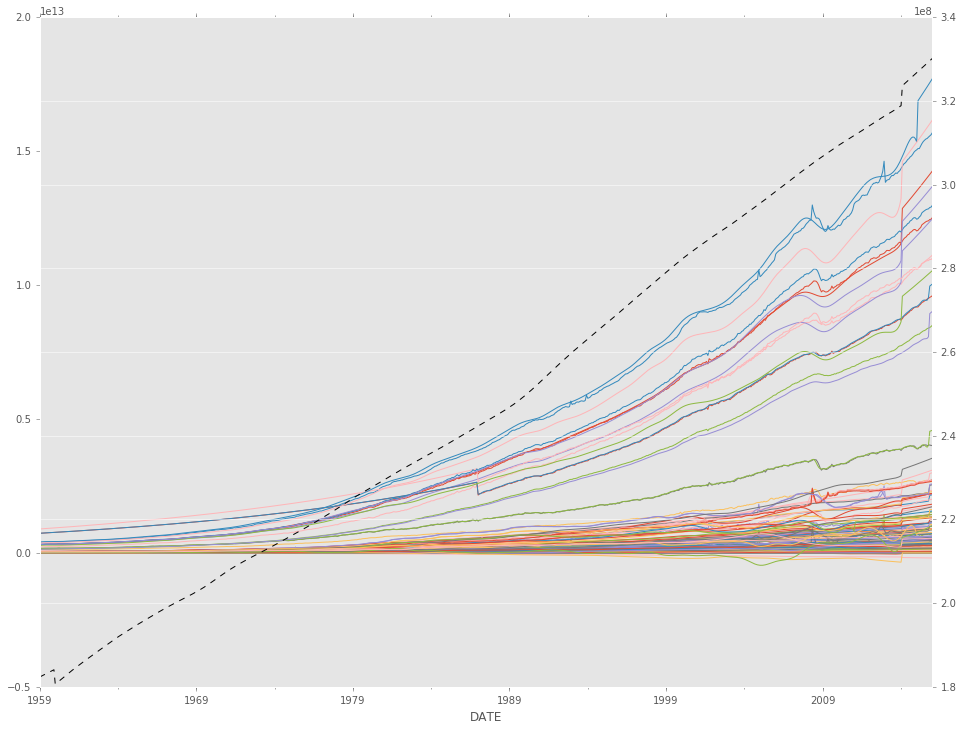

In [34]:
# Plot to check proper import
# personal_data.plot(legend=False)
personal_data_exp.plot(legend=False)
uspop_data.plot(legend=False, style='k--', secondary_y=True)


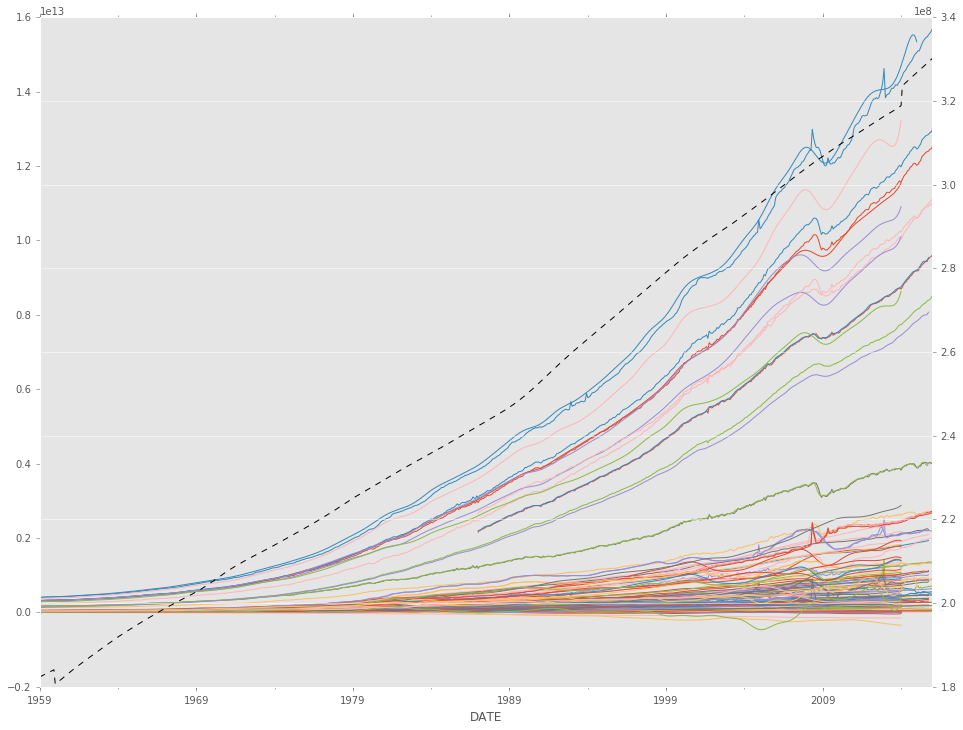

In [31]:
# Plot to check proper import
personal_data.plot(legend=False)
uspop_data.plot(legend=False, style='k--', secondary_y=True)


[  1.09990824e+03  -3.02815086e-03]
[ 4.27899473 -0.00432782]


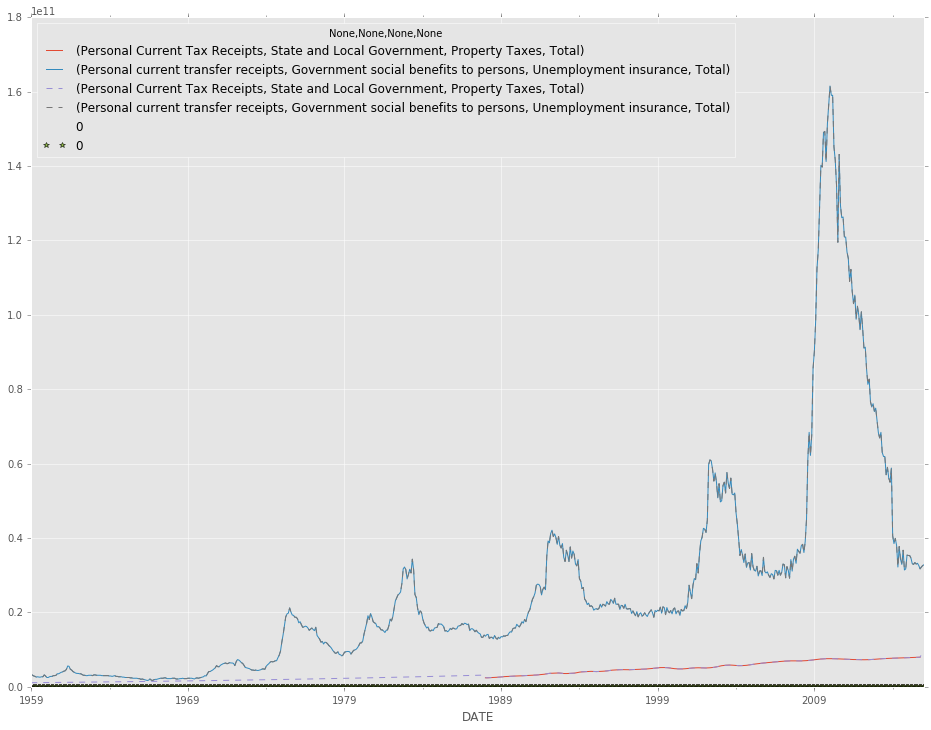

In [32]:
# Plot to check proper import
ax = personal_data[[
    ('Personal Current Tax Receipts', 'State and Local Government', 'Property Taxes', 'Total'),
#     'Personal Current Tax Receipts',
#     'Personal current transfer receipts'
    ('Personal current transfer receipts', 'Government social benefits to persons', 'Unemployment insurance', 'Total')
]].plot(style='-')
personal_data_exp[[
    ('Personal Current Tax Receipts', 'State and Local Government', 'Property Taxes', 'Total'),
#     'Personal Current Tax Receipts',
#     'Personal current transfer receipts'
    ('Personal current transfer receipts', 'Government social benefits to persons', 'Unemployment insurance', 'Total')
]].plot(style='--', ax=ax)

# Function to curve fit to the data
def func(x, a, b):#, c):
    r = a * np.exp(-b * x)# + c
    return r # if (r > 0).all() else np.Inf * np.ones(x.shape)

print models[('Personal Current Tax Receipts', 'State and Local Government', 'Property Taxes', 'Total')]
x = np.array(range(len(personal_data.index)))
y = func(x, *models[('Personal Current Tax Receipts', 'State and Local Government', 'Property Taxes', 'Total')])
pd.DataFrame(y, index=personal_data.index).plot(style='*', ax=ax)

print models[('Personal current transfer receipts', 'Government social benefits to persons', 'Unemployment insurance', 'Total')]
y = func(x, *models[('Personal current transfer receipts', 'Government social benefits to persons', 'Unemployment insurance', 'Total')])
pd.DataFrame(y, index=personal_data.index).plot(style='*', ax=ax)


In [33]:
# # Collapse the heiarchy of categories to the last non Total level
# categories = ['' for x in xrange(len(average_data.columns))]
# for level in xrange(len(average_data.columns.levels)-1, -1, -1):
#     for i, cat in enumerate(average_data.columns.get_level_values(level)):
#         if cat != 'Total' and categories[i] == '':
#             categories[i] = cat

# # Replace multi index with collapsed categories
# average_data.columns = categories


In [13]:
from matplotlib.pylab import plot

x = np.array([399.75, 989.25, 1578.75, 2168.25, 2757.75, 3347.25, 3936.75, 4526.25, 5115.75, 5705.25])
y = np.array([109,62,39,13,10,4,2,0,1,2][::-1])

popt, pcov = curve_fit(func, x, y, p0=(1, 1e-6, 1))

print popt

[  1.96009907e+07  -8.67494603e-07  -1.96043031e+07]
[  7.96378514e+00  -3.49643545e-03  -7.08893433e+00]

[  4.35337218e-01  -9.71142415e-04  -1.16854057e+00]


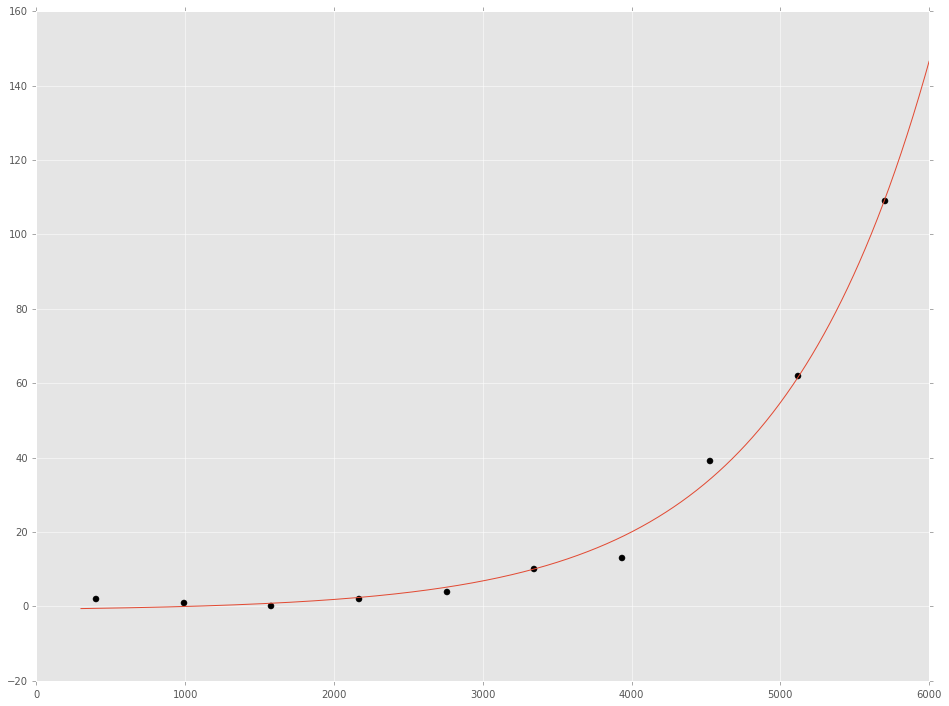

In [14]:
xx = np.linspace(300, 6000, 1000)
yy = func(xx, *popt)
plot(x, y, 'ko')
plot(xx, yy)

In [13]:
average_data.iloc[-24].sort_values()

Personal current transfer receipts                           Government social benefits to persons                                                                          Unemployment insurance                                                                Total                                                                 1.193646e-07
                                                             Other current transfer receipts, from business (net)                                                           Total                                                                                 Total                                                                 1.295958e-07
Personal consumption expenditures                            Net purchases of used autos                                                                                    Total                                                                                 Total                                                       